# Offsides with Mol2Vec

# Implementação da Baseline

In [2]:
from mol2vec.features import mol2alt_sentence, MolSentence, DfVec, sentences2vec
from gensim.models import Word2Vec
from gensim.models import word2vec
from rdkit import Chem
import pandas as pd
import numpy as np
from keras.callbacks import ModelCheckpoint, Callback
import matplotlib.pyplot as plt
import deepchem as dc
from sklearn.model_selection import train_test_split
from skmultilearn.model_selection import iterative_train_test_split
from deepchem.data.datasets import NumpyDataset


Using TensorFlow backend.
/home/mamonteiro/anaconda3/envs/lei/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [3]:
"""
OFFSIDES dataset loader.
"""
from __future__ import division
from __future__ import unicode_literals

import os
import logging
import deepchem

logger = logging.getLogger(__name__)


def load_offsides_for_mol2vec(featurizer='ECFP', split='index', reload=True, K=4):
  """Load OFFSIDES datasets. Does not do train/test split"""
  # Load Sider dataset
  logger.info("About to load Offsides dataset.")
  data_dir = deepchem.utils.get_data_dir()
  if reload:
    save_dir = os.path.join(data_dir, "offsides/" + featurizer + "/" + str(split))

  #dataset_file = os.path.join(data_dir, "muv.csv.gz")
  dataset_file = os.path.join("./", "offsides.csv.gz")
  #if not os.path.exists(dataset_file):
  #  deepchem.utils.download_url(
  #      'http://deepchem.io.s3-website-us-west-1.amazonaws.com/datasets/muv.csv.gz'
  #  )

  OFFSIDES_tasks = sorted([ 'Hepatobiliary disorders',
       'Metabolism and nutrition disorders', 'Product issues', 'Eye disorders',
       'Investigations', 'Musculoskeletal and connective tissue disorders',
       'Gastrointestinal disorders', 'Social circumstances',
       'Immune system disorders', 'Reproductive system and breast disorders',
       'Neoplasms benign, malignant and unspecified (incl cysts and polyps)',
       'General disorders and administration site conditions',
       'Endocrine disorders', 'Surgical and medical procedures',
       'Vascular disorders', 'Blood and lymphatic system disorders',
       'Skin and subcutaneous tissue disorders',
       'Congenital, familial and genetic disorders',
       'Infections and infestations',
       'Respiratory, thoracic and mediastinal disorders',
       'Psychiatric disorders', 'Renal and urinary disorders',
       'Pregnancy, puerperium and perinatal conditions',
       'Ear and labyrinth disorders', 'Cardiac disorders',
       'Nervous system disorders',
       'Injury, poisoning and procedural complications'
  ])

  if reload:
    loaded, all_dataset, transformers = deepchem.utils.save.load_dataset_from_disk(save_dir)
    if loaded:
      return OFFSIDES_tasks, all_dataset, transformers

  # Featurize MUV dataset
  logger.info("About to featurize OFFSIDES dataset.")

  if featurizer == 'ECFP':
    featurizer = deepchem.feat.CircularFingerprint(size=1024)
  elif featurizer == 'GraphConv':
    featurizer = deepchem.feat.ConvMolFeaturizer()
  elif featurizer == 'Weave':
    featurizer = deepchem.feat.WeaveFeaturizer()
  elif featurizer == 'Raw':
    featurizer = deepchem.feat.RawFeaturizer()

  loader = deepchem.data.CSVLoader(
      tasks=OFFSIDES_tasks, smiles_field="smiles", featurizer=featurizer)
  dataset = loader.featurize(dataset_file)

  # Initialize transformers
  transformers = [
      deepchem.trans.BalancingTransformer(transform_w=True, dataset=dataset)
  ]
  logger.info("About to transform data")
  for transformer in transformers:
    dataset = transformer.transform(dataset)

  if split == None:
    return OFFSIDES_tasks, (dataset, None, None), transformers

  splitters = {
      'index': deepchem.splits.IndexSplitter(),
      'random': deepchem.splits.RandomSplitter(),
      'scaffold': deepchem.splits.ScaffoldSplitter(),
      'task': deepchem.splits.TaskSplitter()
  }
  splitter = splitters[split]
  if split == 'task':
    fold_datasets = splitter.k_fold_split(dataset, K)
    all_dataset = fold_datasets
  else:
    train, valid, test = splitter.train_valid_test_split(dataset)
    all_dataset = (train, valid, test)
    if reload:
      deepchem.utils.save.save_dataset_to_disk(save_dir, train, valid, test,
                                               transformers)
  return OFFSIDES_tasks, all_dataset, transformers


In [4]:
tasks, datasets, transformers = load_offsides_for_mol2vec()
train_dataset, valid_dataset, test_dataset = datasets
train_smiles = train_dataset.ids
valid_smiles = valid_dataset.ids
test_smiles = test_dataset.ids

Loading raw samples now.
shard_size: 8192
About to start loading CSV from /home/mamonteiro/source-code/Project-LEI/offsides/offsides.csv.gz
Loading shard 1 of size 8192.
Featurizing sample 0
TIMING: featurizing shard 0 took 1.833 s
TIMING: dataset construction took 1.870 s
Loading dataset from disk.
TIMING: dataset construction took 0.039 s
Loading dataset from disk.
TIMING: dataset construction took 0.034 s
Loading dataset from disk.
TIMING: dataset construction took 0.016 s
Loading dataset from disk.
TIMING: dataset construction took 0.018 s
Loading dataset from disk.


In [5]:
len(train_dataset),len(valid_smiles),len(test_smiles)

(704, 88, 89)

In [6]:
train_dataset.ids

array(['CC12CCC3C(C1CCC2=O)CC=C4C3(CCC(C4)O)C', 'C[N+](C)(C)CC(CC(=O)O)O',
       'C(CC(=O)O)CN',
       'C1C(N(C2=C(N1)NC(=NC2=O)N)C=O)CNC3=CC=C(C=C3)C(=O)NC(CCC(=O)O)C(=O)O',
       'CCCCCC(C=CC1C(CC(=O)C1CC=CCCCC(=O)O)O)O',
       'CCCCCC(C=CC1C(CC2C1CC(=CCCCC(=O)O)O2)O)O',
       'C1=NC2=C(C(=N1)N)N=CN2C3C(C(C(O3)CO)O)O',
       'C(C1C(C(C(C(O1)O)O)O)O)O',
       'CCCCCC(C=CC1C(CC(=O)C1CCCCCCC(=O)O)O)O',
       'C(C(C1C(=O)C(=C(O1)O)O)O)O',
       'C1=NC2=C(C(=N1)N)N=CN2C3C(C(C(O3)COP(=O)(O)OP(=O)(O)OP(=O)(O)O)O)O',
       'C1C2C(C(S1)CCCCC(=O)O)NC(=O)N2', '[Ca+2]',
       'C1=CC(=CC=C1C(C(CO)NC(=O)C(Cl)Cl)O)[N+](=O)[O-]',
       'CC(C)CCCC(C)C1CCC2C1(CCC3C2CC=C4C3(CCC(C4)O)C)C', '[Cl-]',
       'C1=CC=C(C(=C1)C(=O)O)O', 'C(C(C(=O)O)N)C(=O)O',
       'CC(C(=O)C1=CC(=CC=C1)Cl)NC(C)(C)C',
       'CC12CCC3C(C1CCC2O)CCC4=C3C=CC(=C4)O', 'C(C(C(C(C(CO)O)O)O)O)O',
       'C(CCC(=O)O)CCN', 'CC(=O)NC(CS)C(=O)O',
       'C1=CN(C(=O)N=C1N)C2C(C(C(O2)CO)O)O', 'C(CS(=O)(=O)O)S',
       'C(C(C(C

In [7]:
#df['smiles'][0:5]

In [8]:
# Get SMILES from file
def getSMILES(filepath):
    df = pd.read_csv(filepath)    
    #smiles = list(df['SMILES or PubChem ID'].dropna())
    smiles_df = df[['smiles']].dropna()
    # some cases have 2 SMILES per compound, which I think are isomers (by looking at the molecular drawings)
    # keeping only the first SMILE string:
    #smiles = [x.split(';')[0] for x in smiles]
    return smiles_df

In [9]:
# Generate molecules from SMILES strings
def generateEmbeddings(smiles_df, trained_model):
    smiles = list(smiles_df['smiles'])
    smiles = [x.split(';')[0] for x in smiles]
    # SMILES to Mol
    molecules = [Chem.MolFromSmiles(x) for x in smiles]
    # Load previously trained mol2vec model
    model = Word2Vec.load(trained_model)
    # Convert molecules to sentences and then to embeddings
    sentences = [mol2alt_sentence(x, 1) for x in molecules]
    vectors = [DfVec(x) for x in sentences2vec(sentences, model, unseen='UNK')]
    vec_df = pd.DataFrame(data=np.array([x.vec for x in vectors]))
    vec_df.columns = ['mol2vec_' + str(x+1) for x in vec_df.columns.values]
    vec_df.index = smiles_df.index.values
    return pd.concat([smiles_df, vec_df], axis=1)

In [10]:
def createDataset(original_data, embeddings_df, output):
    original_df = pd.read_csv(original_data)
    df = original_df.merge(embeddings_df, how='outer', on="smiles")
    df.to_csv(output, index=False)    

In [11]:
train_smiles_from_offsides=train_dataset.ids
valid_smiles_from_offsides=valid_dataset.ids
test_smiles_from_offsides=test_dataset.ids

In [12]:
type(train_smiles_from_offsides)

numpy.ndarray

In [13]:
train_smiles_from_offsides=pd.DataFrame(train_smiles_from_offsides,  columns=['smiles'])
valid_smiles_from_offsides=pd.DataFrame(valid_smiles_from_offsides,  columns=['smiles'])
test_smiles_from_offsides=pd.DataFrame(test_smiles_from_offsides,  columns=['smiles'])

In [14]:
len(train_smiles_from_offsides)

704

In [15]:
import os
 
dirpath = os.getcwd()
print("current directory is : " + dirpath)
foldername = os.path.basename(dirpath)
print("Directory name is : " + foldername)

current directory is : /home/mamonteiro/source-code/Project-LEI/offsides
Directory name is : offsides


In [16]:
#Estas 3 linhas deveriam ser feitas de outra maneira
#Deveriamos fazer o mesmo com o dataset completo mas neste momento vai ficar assim pelo receio que tenho de nao ter o dataset dividido como suposto

train_embeddings_generated_from_mol2vec = generateEmbeddings(train_smiles_from_offsides, '/home/mamonteiro/source-code/Project-LEI/mol2vec/examples/models/model_300dim.pkl')
valid_embeddings_generated_from_mol2vec = generateEmbeddings(valid_smiles_from_offsides, '/home/mamonteiro/source-code/Project-LEI/mol2vec/examples/models/model_300dim.pkl')
test_embeddings_generated_from_mol2vec = generateEmbeddings(test_smiles_from_offsides, '/home/mamonteiro/source-code/Project-LEI/mol2vec/examples/models/model_300dim.pkl')

In [17]:
train_embeddings_generated_from_mol2vec.head()

smiles  mol2vec_1  mol2vec_2  \
0              CC12CCC3C(C1CCC2=O)CC=C4C3(CCC(C4)O)C  -1.687902  -4.574107   
1                            C[N+](C)(C)CC(CC(=O)O)O   2.769547  -3.059868   
2                                       C(CC(=O)O)CN  -0.599405   0.307458   
3  C1C(N(C2=C(N1)NC(=NC2=O)N)C=O)CNC3=CC=C(C=C3)C...   1.644671  -4.325292   
4            CCCCCC(C=CC1C(CC(=O)C1CC=CCCCC(=O)O)O)O  -0.658838  -3.338789   

   mol2vec_3  mol2vec_4  mol2vec_5  mol2vec_6  mol2vec_7  mol2vec_8  \
0  -3.788245   0.820349  -1.165568  -7.593350  -8.685431   3.990403   
1  -1.797269  -0.953987   4.924242   0.454827  -9.468398   1.997672   
2  -0.714178  -0.674214   2.840279  -0.157350  -3.893690  -0.316774   
3  -5.132446   4.536877   2.365319  -1.383428 -16.086567  -2.104912   
4  -3.176840  -0.045156   6.762016  -4.120831 -17.303051  -0.583435   

   mol2vec_9  ...  mol2vec_291  mol2vec_292  mol2vec_293  mol2vec_294  \
0   0.837541  ...     1.517185    14.211781    -2.282333    -1.685342   
1   2.284252  ...    -1.738315    -0.433908     6.375163     1.494671   
2   1.240166  ...    -0.479649     2.350071     2.795008     2.045637   
3   9.071654  ...    -0.469195    12.227261    11.296147     3.872406   
4   3.757764  ...    -7.855739     6.595695     7.846533     1.867607   

   mol2vec_295  mol2vec_296  mol2vec_297  mol2vec_298  mol2vec_299  \
0   -10.677238    -8.447270   -10.454116    -1.177601   -10.021074   
1    -5.280170    -2.230168     3.010262    -5.875394    -4.850206   
2    -3.803340    -0.811048     0.601341    -3.857245    -3.734070   
3   -12.161841    -6.847059    -4.032226    -7.607767   -16.263073   
4    -9.597700    -8.820236    -5.526588    -5.572998   -11.429805   

   mol2vec_300  
0     2.415180  
1     0.262021  
2    -1.403350  
3    -3.654300  
4    -4.801989  

[5 rows x 301 columns]

In [18]:
len(train_embeddings_generated_from_mol2vec),len(valid_embeddings_generated_from_mol2vec),len(test_embeddings_generated_from_mol2vec) 

(704, 88, 89)

In [19]:
train_embeddings_generated_from_mol2vec.iloc[0][0]

'CC12CCC3C(C1CCC2=O)CC=C4C3(CCC(C4)O)C'

In [20]:
import os
import deepchem as dc


#current_dir = os.path.dirname(os.path.realpath("__file__"))
#dataset_file = "medium_muv.csv.gz"


#dataset = dc.utils.save.load_from_disk('/home/mamonteiro/source-code/Project-LEI/SIDER/sider_embeddings.csv')
#print("Columns of dataset: %s" % str(dataset.columns.values))
#print("Number of examples in dataset: %s" % str(dataset.shape[0]))

The dataset that we must manipulate is thhe follwoing one: dataset

In this dataset has as columns the SMILES
                               The side efects
                               and finally the embeddings
        
We need to split this dataset in order to provide this data to multitask model

In [21]:
#dataset=dataset.drop(['smiles'], axis=1)

In [22]:
train_embeddings=train_embeddings_generated_from_mol2vec.drop(['smiles'], axis=1)
valid_embeddings=valid_embeddings_generated_from_mol2vec.drop(['smiles'], axis=1)
test_embeddings=test_embeddings_generated_from_mol2vec.drop(['smiles'], axis=1)

In [23]:
train_embeddings.head()

mol2vec_1  mol2vec_2  mol2vec_3  mol2vec_4  mol2vec_5  mol2vec_6  \
0  -1.687902  -4.574107  -3.788245   0.820349  -1.165568  -7.593350   
1   2.769547  -3.059868  -1.797269  -0.953987   4.924242   0.454827   
2  -0.599405   0.307458  -0.714178  -0.674214   2.840279  -0.157350   
3   1.644671  -4.325292  -5.132446   4.536877   2.365319  -1.383428   
4  -0.658838  -3.338789  -3.176840  -0.045156   6.762016  -4.120831   

   mol2vec_7  mol2vec_8  mol2vec_9  mol2vec_10  ...  mol2vec_291  mol2vec_292  \
0  -8.685431   3.990403   0.837541   -1.743650  ...     1.517185    14.211781   
1  -9.468398   1.997672   2.284252   -0.435059  ...    -1.738315    -0.433908   
2  -3.893690  -0.316774   1.240166   -1.818650  ...    -0.479649     2.350071   
3 -16.086567  -2.104912   9.071654    2.479271  ...    -0.469195    12.227261   
4 -17.303051  -0.583435   3.757764   -3.908807  ...    -7.855739     6.595695   

   mol2vec_293  mol2vec_294  mol2vec_295  mol2vec_296  mol2vec_297  \
0    -2.282333    -1.685342   -10.677238    -8.447270   -10.454116   
1     6.375163     1.494671    -5.280170    -2.230168     3.010262   
2     2.795008     2.045637    -3.803340    -0.811048     0.601341   
3    11.296147     3.872406   -12.161841    -6.847059    -4.032226   
4     7.846533     1.867607    -9.597700    -8.820236    -5.526588   

   mol2vec_298  mol2vec_299  mol2vec_300  
0    -1.177601   -10.021074     2.415180  
1    -5.875394    -4.850206     0.262021  
2    -3.857245    -3.734070    -1.403350  
3    -7.607767   -16.263073    -3.654300  
4    -5.572998   -11.429805    -4.801989  

[5 rows x 300 columns]

In [24]:
train_embeddings.isnull().any().any()

False

In [25]:
len(train_embeddings.columns)

300

In [26]:
len(train_embeddings)

704

In [27]:
NCA1 = 100
NCA2 = 100
DROPRATE = 0.2
EP = 50
BATCH_SIZE = 128
VAL_RATIO = 0.1
TEST_RATIO = 0.1

In [28]:
# VERFICAR SE É NECESSÁRIO
from deepchem.data.datasets import NumpyDataset # import NumpyDataset

#NESTE MOMENTO NAO TENHO
#dataset_with_weights = NumpyDataset(sideEfects) # creates numpy dataset object


In [29]:
#dataset_with_weights

In [30]:
train_embeddings_dataset = dc.data.NumpyDataset(train_embeddings,
                                                train_dataset.y,
                                                train_dataset.w,
                                                train_dataset.ids)

In [31]:
valid_embeddings_dataset = dc.data.NumpyDataset(valid_embeddings,
                                                valid_dataset.y,
                                                valid_dataset.w,
                                                valid_dataset.ids)

In [32]:
test_embeddings_dataset = dc.data.NumpyDataset(test_embeddings,
                                                test_dataset.y,
                                                test_dataset.w,
                                                test_dataset.ids)

In [33]:
nb_epochs=[50,100, 150, 200,250,300,400,500,1000]
losses = []
loss =0

In [34]:
model = dc.models.MultitaskClassifier(n_tasks=27,
                                      n_features=300,
                                      layer_sizes=[512])

for epoch in nb_epochs :
    loss = model.fit(train_embeddings_dataset, epoch=epoch)
    print("Epoch %d loss: %f" % (epoch, loss))
    losses.append(loss)

Instructions for updating:
Colocations handled automatically by placer.


Instructions for updating:
Colocations handled automatically by placer.


Epoch 50 loss: 3075.037043
Epoch 100 loss: 2661.236361
Epoch 150 loss: 2530.917671
Epoch 200 loss: 2449.768308
Epoch 250 loss: 2360.078321
Instructions for updating:
Use standard file APIs to delete files with this prefix.


Instructions for updating:
Use standard file APIs to delete files with this prefix.


Epoch 300 loss: 2311.119470
Epoch 400 loss: 2253.138658
Epoch 500 loss: 2198.767750
Epoch 1000 loss: 2175.769902


In [35]:
import matplotlib.pyplot as plot

plot.figure(figsize=(10,7))
plot.ylabel("Loss")
plot.xlabel("Epoch")
x = nb_epochs
y = losses
plot.scatter(x, y)
plot

<module 'matplotlib.pyplot' from '/home/mamonteiro/anaconda3/envs/lei/lib/python3.6/site-packages/matplotlib/pyplot.py'>

In [36]:
import numpy as np
metric = dc.metrics.Metric(dc.metrics.roc_auc_score, np.mean, mode="classification")
train_score = model.evaluate(train_embeddings_dataset, [metric], transformers)
print('Training set ROC AUC:', train_score)


computed_metrics: [0.8743402225755168, 0.9062433308111674, 0.7724328619792518, 0.9827893175074184, 0.9438889371938672, 0.8166565554432086, 0.8111287384687702, 0.8511806130903066, 0.9263753460936561, 0.9392143527963989, 0.7951002414544476, 0.8095498450883907, 0.7190770538984824, 0.9019292604501608, 0.8994063680518078, 0.7810888303819381, 0.8130704833918445, 0.9176378098409175, 0.9574968071519796, 0.8401208342083581, 0.8885519462719298, 0.8423425538909501, 0.8655492566668594, 0.8356964478227049, 0.9278549382716049, 0.7572554295598692, 0.9106236666045279]
Training set ROC AUC: {'mean-roc_auc_score': 0.8624667425543087}


In [37]:
valid_score = model.evaluate(valid_embeddings_dataset, [metric], transformers)
print('Validation set ROC AUC:', valid_score)

computed_metrics: [0.47951807228915666, 0.4534883720930233, 0.4945175438596491, 0.8620689655172413, 0.2906976744186046, 0.686046511627907, 0.526027397260274, 0.4656084656084656, 0.5853658536585366, 0.7093023255813953, 0.54337899543379, 0.4418859649122807, 0.5539529914529915, 0.25098039215686274, 0.6235294117647059, 0.6512013256006628, 0.5223577235772358, 0.6918604651162792, 0.5058139534883721, 0.5254901960784313, 0.6588235294117648, 0.592156862745098, 0.2705882352941177, 0.478125, 0.455421686746988, 0.49350649350649356, 0.3953488372093023]
Validation set ROC AUC: {'mean-roc_auc_score': 0.5261875276448011}


In [38]:
test_score = model.evaluate(test_embeddings_dataset, [metric], transformers)
print('\n')
print('Validation set ROC AUC:', test_score)

computed_metrics: [0.11363636363636365, 0.48062015503875966, 0.5606060606060606, 0.3522727272727273, 0.7911764705882354, 0.35888501742160284, 0.4263565891472868, 0.32352941176470595, nan, 0.7286821705426356, 0.5205627705627706, 0.4988344988344988, 0.4742324561403509, nan, 0.39080459770114945, 0.5678137651821862, 0.18992248062015504, 0.9545454545454546, nan, 0.5502008032128514, 0.8295454545454546, 0.529320987654321, 0.5977011494252873, 0.5401606425702812, 0.41860465116279066, 0.5792483660130718, nan]


Validation set ROC AUC: {'mean-roc_auc_score': 0.5120549149647392}


/home/mamonteiro/anaconda3/envs/lei/lib/python3.6/site-packages/deepchem/metrics/__init__.py:368: UserWarning: Error calculating metric mean-roc_auc_score: Only one class present in y_true. ROC AUC score is not defined in that case.
  warnings.warn("Error calculating metric %s: %s" % (self.name, e))
/home/mamonteiro/anaconda3/envs/lei/lib/python3.6/site-packages/deepchem/metrics/__init__.py:368: UserWarning: Error calculating metric mean-roc_auc_score: Only one class present in y_true. ROC AUC score is not defined in that case.
  warnings.warn("Error calculating metric %s: %s" % (self.name, e))
/home/mamonteiro/anaconda3/envs/lei/lib/python3.6/site-packages/deepchem/metrics/__init__.py:368: UserWarning: Error calculating metric mean-roc_auc_score: Only one class present in y_true. ROC AUC score is not defined in that case.
  warnings.warn("Error calculating metric %s: %s" % (self.name, e))
/home/mamonteiro/anaconda3/envs/lei/lib/python3.6/site-packages/deepchem/metrics/__init__.py:368:

[(0, 0.5376576607129762)]

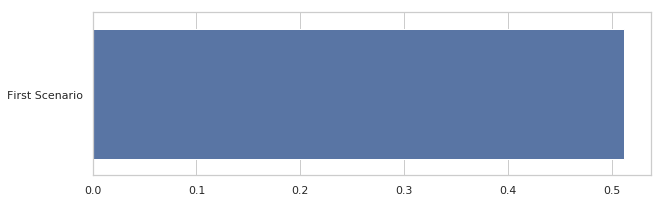

In [39]:
import seaborn as sns

sns.set(rc={'figure.figsize':(10,3)})
sns.set(style="whitegrid")
ax = sns.barplot(x=[test_score['mean-roc_auc_score']],
                 y=['First Scenario'])
ax.set(xlim=(0, None))


# Valores muito fracos - Melhorar ....

# Valores com hyperparameters

In [40]:
sider_tasks = sorted([ 'Hepatobiliary disorders',
   'Metabolism and nutrition disorders', 'Product issues', 'Eye disorders',
   'Investigations', 'Musculoskeletal and connective tissue disorders',
   'Gastrointestinal disorders', 'Social circumstances',
   'Immune system disorders', 'Reproductive system and breast disorders',
   'Neoplasms benign, malignant and unspecified (incl cysts and polyps)',
   'General disorders and administration site conditions',
   'Endocrine disorders', 'Surgical and medical procedures',
   'Vascular disorders', 'Blood and lymphatic system disorders',
   'Skin and subcutaneous tissue disorders',
   'Congenital, familial and genetic disorders',
   'Infections and infestations',
   'Respiratory, thoracic and mediastinal disorders',
   'Psychiatric disorders', 'Renal and urinary disorders',
   'Pregnancy, puerperium and perinatal conditions',
   'Ear and labyrinth disorders', 'Cardiac disorders',
   'Nervous system disorders',
   'Injury, poisoning and procedural complications'
])


In [41]:
params_dict = {"activation": ["relu","sigmoid","tanh"],
               "optimizer": ['RMSprop','adam'],
               "momentum": [.9],
               "dropouts": [.5,0.2],
               "nb_layers": [512],
               "penalty": [0.]
              }

n_features = train_dataset.get_data_shape()[0]

def model_builder(model_params, model_dir):
    model = dc.models.MultitaskClassifier(
    len(sider_tasks), n_features, **model_params)
    return model

In [42]:
train_dataset.get_data_shape()[0]

1024

In [43]:

metric = dc.metrics.Metric(dc.metrics.roc_auc_score, np.mean)
optimizer = dc.hyper.HyperparamOpt(model_builder)
best_dnn, best_hyperparams, all_results = optimizer.hyperparam_search(
    params_dict, train_dataset, valid_dataset, [], metric)

Fitting model 1/12
hyperparameters: {'activation': 'relu', 'optimizer': 'RMSprop', 'momentum': 0.9, 'dropouts': 0.5, 'nb_layers': 512, 'penalty': 0.0}
computed_metrics: [0.6602409638554216, 0.3023255813953488, 0.5032894736842106, 0.29885057471264365, 0.37790697674418605, 0.6162790697674418, 0.5388127853881279, 0.4814814814814815, 0.7113821138211383, 0.27325581395348836, 0.6264840182648402, 0.5657894736842105, 0.5389957264957265, 0.8235294117647058, 0.4745098039215686, 0.5874067937033969, 0.4166666666666667, 0.9418604651162791, 0.20930232558139533, 0.6509803921568627, 0.5254901960784314, 0.4980392156862745, 0.6784313725490196, 0.6328125, 0.4746987951807229, 0.4510035419126328, 0.36627906976744184]
Model 1/12, Metric mean-roc_auc_score, Validation set 0: 0.526893
	best_validation_score so far: 0.526893
Fitting model 2/12
hyperparameters: {'activation': 'relu', 'optimizer': 'RMSprop', 'momentum': 0.9, 'dropouts': 0.2, 'nb_layers': 512, 'penalty': 0.0}
computed_metrics: [0.727710843373494,

computed_metrics: [0.689156626506024, 0.29069767441860467, 0.5032894736842105, 0.3563218390804598, 0.41860465116279066, 0.6453488372093024, 0.5607305936073059, 0.45502645502645506, 0.7052845528455285, 0.3081395348837209, 0.6219178082191781, 0.5120614035087718, 0.5443376068376069, 0.788235294117647, 0.45882352941176474, 0.5584092792046396, 0.4532520325203252, 0.9476744186046511, 0.28488372093023256, 0.6509803921568628, 0.47058823529411764, 0.45490196078431366, 0.7176470588235294, 0.615625, 0.5036144578313253, 0.461629279811098, 0.3488372093023256]
Model 11/12, Metric mean-roc_auc_score, Validation set 10: 0.530593
	best_validation_score so far: 0.539932
Fitting model 12/12
hyperparameters: {'activation': 'tanh', 'optimizer': 'adam', 'momentum': 0.9, 'dropouts': 0.2, 'nb_layers': 512, 'penalty': 0.0}
computed_metrics: [0.7421686746987952, 0.33720930232558144, 0.5032894736842105, 0.31034482758620685, 0.4593023255813954, 0.6395348837209303, 0.5534246575342466, 0.4814814814814815, 0.7052845

In [44]:
best_dnn

MultitaskClassifier(activation_fns=None, bias_init_consts=None, dropouts=None,
                    layer_sizes=None, n_classes=2, n_features=1024, n_tasks=27,
                    weight_decay_penalty=None, weight_decay_penalty_type=None,
                    weight_init_stddevs=None)

In [45]:
best_hyperparams

('tanh', 'adam', 0.9, 0.2, 512, 0.0)

In [46]:
obj=best_dnn.fit(train_dataset,**params_dict)

In [47]:
metric = dc.metrics.Metric(dc.metrics.roc_auc_score, np.mean)

In [48]:
train_scores = best_dnn.evaluate(train_dataset, [metric], transformers)
print(train_scores)

computed_metrics: [0.9931743508214097, 0.9971092097860039, 0.9826371879864582, 0.9996043521266074, 0.9990435614294408, 0.9841321199865184, 0.9863564251718667, 0.9860061101905551, 0.9946069579872396, 0.9957252501700184, 0.9584900263328369, 0.975835933061032, 0.9354886185243327, 0.9948435416830053, 0.9888983116182253, 0.9579290943845349, 0.9747556035646772, 0.9974334073251943, 0.9988250319284803, 0.9971245335444163, 0.9937123081140351, 0.9883686344495061, 0.989023543703361, 0.9886597797459027, 0.998208774250441, 0.9725707696109387, 0.9974523084570932]
{'mean-roc_auc_score': 0.9861487313316344}


In [49]:
valid_scores = best_dnn.evaluate(valid_dataset, [metric], transformers)
print(valid_scores)

computed_metrics: [0.7012048192771084, 0.34302325581395343, 0.5010964912280702, 0.3563218390804598, 0.38953488372093026, 0.6104651162790697, 0.5680365296803653, 0.5343915343915344, 0.6707317073170731, 0.27906976744186046, 0.6474885844748859, 0.6567982456140351, 0.561965811965812, 0.792156862745098, 0.5333333333333334, 0.5393537696768849, 0.565040650406504, 0.8313953488372093, 0.27325581395348836, 0.7803921568627452, 0.5176470588235295, 0.5529411764705883, 0.6235294117647059, 0.7171875000000001, 0.5036144578313253, 0.5064935064935066, 0.32558139534883723]
{'mean-roc_auc_score': 0.5511870751419599}


In [50]:
test_scores_v1 = best_dnn.evaluate(test_dataset, [metric], transformers)
print(test_scores_v1)

computed_metrics: [0.30681818181818177, 0.22093023255813957, 0.5151515151515151, 0.6818181818181819, 0.7529411764705882, 0.25609756097560976, 0.5542635658914727, 0.526470588235294, nan, 0.7829457364341086, 0.6363636363636364, 0.43356643356643354, 0.4161184210526316, nan, 0.6264367816091954, 0.5647773279352226, 0.3875968992248062, 0.9545454545454546, nan, 0.5983935742971888, 0.7386363636363636, 0.5679012345679012, 0.867816091954023, 0.4056224899598393, 0.49612403100775193, 0.5906862745098039, nan]
{'mean-roc_auc_score': 0.5600879023297105}


/home/mamonteiro/anaconda3/envs/lei/lib/python3.6/site-packages/deepchem/metrics/__init__.py:368: UserWarning: Error calculating metric mean-roc_auc_score: Only one class present in y_true. ROC AUC score is not defined in that case.
  warnings.warn("Error calculating metric %s: %s" % (self.name, e))
/home/mamonteiro/anaconda3/envs/lei/lib/python3.6/site-packages/deepchem/metrics/__init__.py:368: UserWarning: Error calculating metric mean-roc_auc_score: Only one class present in y_true. ROC AUC score is not defined in that case.
  warnings.warn("Error calculating metric %s: %s" % (self.name, e))
/home/mamonteiro/anaconda3/envs/lei/lib/python3.6/site-packages/deepchem/metrics/__init__.py:368: UserWarning: Error calculating metric mean-roc_auc_score: Only one class present in y_true. ROC AUC score is not defined in that case.
  warnings.warn("Error calculating metric %s: %s" % (self.name, e))
/home/mamonteiro/anaconda3/envs/lei/lib/python3.6/site-packages/deepchem/metrics/__init__.py:368:

In [53]:
import seaborn as sns

sns.set(rc={'figure.figsize':(11,6)})
sns.set(style="whitegrid")
ax = sns.barplot(x=[test_score['mean-roc_auc_score'],test_scores_v1['mean-roc_auc_score']],
                 y=['First Scenario','Second Scenario'])
ax.set(xlim=(0, None))

[(0, 0.5880922974461961)]

In [54]:
print(test_score['mean-roc_auc_score'])
print(test_scores_v1['mean-roc_auc_score'])

0.5120549149647392
0.5600879023297105
